# **Projeto AM 2024.2 (Francisco)** - Questão 2

Equipe:
* Beatriz Andrade de Miranda - bam2@cin.ufpe.br
* Camila Siqueira Lins - csl2@cin.ufpe.br
* Luisa Cavalcante - lncc@cin.ufpe.br
* Nicolly Lira Albuquerque - nla@cin.ufpe.br


## Sumário

* [Questão 2a](#scrollTo=1369ntQFYBe8)
* [Questão 2b](#scrollTo=-YUFx3-JcRwg)
* [Questão 2c](#scrollTo=WsuUxlTWcShS)
* [Questão 2d](#scrollTo=O6Me_xWIcS1t)

In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

In [ ]:
# Dataset SPECTF heart
spectf_heart = fetch_ucirepo(id=96)

X = spectf_heart.data.features
y = spectf_heart.data.targets.values.ravel()

In [ ]:
print(spectf_heart.metadata)

{'uci_id': 96, 'name': 'SPECTF Heart', 'repository_url': 'https://archive.ics.uci.edu/dataset/96/spectf+heart', 'data_url': 'https://archive.ics.uci.edu/static/public/96/data.csv', 'abstract': 'Data on cardiac Single Proton Emission Computed Tomography (SPECT) images. Each patient classified into two categories: normal and abnormal.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 267, 'num_features': 44, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['diagnosis'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2001, 'last_updated': 'Tue Mar 19 2024', 'dataset_doi': '10.24432/C5N015', 'creators': ['Krzysztof Cios', 'Lukasz Kurgan', 'Lucy Goodenday'], 'intro_paper': None, 'additional_info': {'summary': "The dataset describes diagnosing of cardiac Single Proton Emission Computed Tomography (SPECT) images. Each of the patients is classified into t

In [ ]:
print(spectf_heart.variables)

         name     role     type demographic description units missing_values
0   diagnosis   Target  Integer        None        None  None             no
1         F1R  Feature  Integer        None        None  None             no
2         F1S  Feature  Integer        None        None  None             no
3         F2R  Feature  Integer        None        None  None             no
4         F2S  Feature  Integer        None        None  None             no
5         F3R  Feature  Integer        None        None  None             no
6         F3S  Feature  Integer        None        None  None             no
7         F4R  Feature  Integer        None        None  None             no
8         F4S  Feature  Integer        None        None  None             no
9         F5R  Feature  Integer        None        None  None             no
10        F5S  Feature  Integer        None        None  None             no
11        F6R  Feature  Integer        None        None  None             no

Funções

In [ ]:
# Calcular as métricas
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    error_rate = 1 - accuracy

    return error_rate, precision, recall, f1

In [ ]:
# Calcular o intervalo de confiança via bootstrap
def bootstrap_ci(clf, X, y, n_iterations=1000, alpha=0.05):
    metrics = []

    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y)
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X)
        metrics.append(compute_metrics(y, y_pred))

    metrics = np.array(metrics)

    # Para cada métrica (taxa de erro, precisão, recall, F1), calcular o Intervalo de Confiança
    intervalo_confianca = []
    for i in range(metrics.shape[1]):
        ci_lower = np.percentile(metrics[:, i], 100 * (alpha / 2))
        ci_upper = np.percentile(metrics[:, i], 100 * (1 - alpha / 2))
        mean_est = np.mean(metrics[:, i])
        intervalo_confianca.append((mean_est, ci_lower, ci_upper))

    return intervalo_confianca

## Questão 2a

Considere novamente o dataset "SPECTF" com duas classes a priori.

a) Use validação cruzada estratificada “30 × 10-folds” para avaliar e comparar os 5
classificadores:
* i) bayesiano gaussiano
* ii) bayesiano baseado em k-vizinhos
* iii) bayesiano baseado na janela de Parzen
* iv) regressão logística
* v) usando a regra do voto majoritário a partir dos 4 primeiros classificadores

Quando necessario, faça validação cruzada 5-folds nos 9 folds restantes para fazer ajuste de hiper-parametros e depois treine o modelo novamente com o conjunto aprendizagem de 9-folds usando os valores selecionados para os
hiper-parametros. Use amostragem estratificada.

In [ ]:
# Configuração da validação cruzada 30x10-folds
skf = StratifiedKFold(n_splits=10)

In [ ]:
# Inicialização dos classificadores
gnb = GaussianNB()
knn = KNeighborsClassifier()
parzen = KNeighborsClassifier(weights='distance')  # Aproximação da janela de Parzen
logreg = LogisticRegression(max_iter=10000)

In [ ]:
# Classificador de voto majoritário
voting_clf = VotingClassifier(estimators=[('gnb', gnb), ('knn', knn), ('parzen', parzen), ('logreg', logreg)], voting='hard')

In [ ]:
# Inicializar listas para armazenar as métricas de cada classificador
accuracies_gnb, f1_scores_gnb, error_rates_gnb, precisions_gnb, coverages_gnb = [], [], [], [], []
accuracies_knn, f1_scores_knn, error_rates_knn, precisions_knn, coverages_knn = [], [], [], [], []
accuracies_parzen, f1_scores_parzen, error_rates_parzen, precisions_parzen, coverages_parzen = [], [], [], [], []
accuracies_logreg, f1_scores_logreg, error_rates_logreg, precisions_logreg, coverages_logreg = [], [], [], [], []
accuracies_voting, f1_scores_voting, error_rates_voting, precisions_voting, coverages_voting = [], [], [], [], []


In [ ]:
# Repetir a validação cruzada 30 vezes para obter 300 resultados
for _ in range(30):  # 30 repetições
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Ajuste de hiperparâmetros usando GridSearchCV para KNN e Regressão Logística
        param_grid_knn = {'n_neighbors': [3, 5, 7]}
        grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
        grid_knn.fit(X_train, y_train)
        best_knn = grid_knn.best_estimator_

        param_grid_logreg = {'C': [0.01, 0.1, 1, 10]}
        grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5)
        grid_logreg.fit(X_train, y_train)
        best_logreg = grid_logreg.best_estimator_

        # Treinamento dos modelos
        gnb.fit(X_train, y_train)
        best_knn.fit(X_train, y_train)
        parzen.fit(X_train, y_train)
        best_logreg.fit(X_train, y_train)
        voting_clf.fit(X_train, y_train)

        # Previsões
        y_pred_gnb = gnb.predict(X_test)
        y_pred_knn = best_knn.predict(X_test)
        y_pred_parzen = parzen.predict(X_test)
        y_pred_logreg = best_logreg.predict(X_test)
        y_pred_voting = voting_clf.predict(X_test)

        # Calcular e armazenar as métricas para cada classificador
        # GaussianNB
        accuracies_gnb.append(accuracy_score(y_test, y_pred_gnb))
        f1_scores_gnb.append(f1_score(y_test, y_pred_gnb, average='macro'))
        error_rates_gnb.append(1 - accuracy_score(y_test, y_pred_gnb))
        precisions_gnb.append(precision_score(y_test, y_pred_gnb, average='macro'))
        coverages_gnb.append(recall_score(y_test, y_pred_gnb, average='macro'))

        # KNN
        accuracies_knn.append(accuracy_score(y_test, y_pred_knn))
        f1_scores_knn.append(f1_score(y_test, y_pred_knn, average='macro'))
        error_rates_knn.append(1 - accuracy_score(y_test, y_pred_knn))
        precisions_knn.append(precision_score(y_test, y_pred_knn, average='macro'))
        coverages_knn.append(recall_score(y_test, y_pred_knn, average='macro'))

        # Parzen
        accuracies_parzen.append(accuracy_score(y_test, y_pred_parzen))
        f1_scores_parzen.append(f1_score(y_test, y_pred_parzen, average='macro'))
        error_rates_parzen.append(1 - accuracy_score(y_test, y_pred_parzen))
        precisions_parzen.append(precision_score(y_test, y_pred_parzen, average='macro'))
        coverages_parzen.append(recall_score(y_test, y_pred_parzen, average='macro'))

        # Logistic Regression
        accuracies_logreg.append(accuracy_score(y_test, y_pred_logreg))
        f1_scores_logreg.append(f1_score(y_test, y_pred_logreg, average='macro'))
        error_rates_logreg.append(1 - accuracy_score(y_test, y_pred_logreg))
        precisions_logreg.append(precision_score(y_test, y_pred_logreg, average='macro'))
        coverages_logreg.append(recall_score(y_test, y_pred_logreg, average='macro'))

        # Voting Classifier
        accuracies_voting.append(accuracy_score(y_test, y_pred_voting))
        f1_scores_voting.append(f1_score(y_test, y_pred_voting, average='macro'))
        error_rates_voting.append(1 - accuracy_score(y_test, y_pred_voting))
        precisions_voting.append(precision_score(y_test, y_pred_voting, average='macro'))
        coverages_voting.append(recall_score(y_test, y_pred_voting, average='macro'))

# Criar o DataFrame com todas as métricas
df_metrics = pd.DataFrame({
    'GaussianNB_Acurácia': accuracies_gnb,
    'GaussianNB_F1': f1_scores_gnb,
    'GaussianNB_ErrorRate': error_rates_gnb,
    'GaussianNB_Precision': precisions_gnb,
    'GaussianNB_Coverage': coverages_gnb,

    'KNN_Acurácia': accuracies_knn,
    'KNN_F1': f1_scores_knn,
    'KNN_ErrorRate': error_rates_knn,
    'KNN_Precision': precisions_knn,
    'KNN_Coverage': coverages_knn,

    'Parzen_Acurácia': accuracies_parzen,
    'Parzen_F1': f1_scores_parzen,
    'Parzen_ErrorRate': error_rates_parzen,
    'Parzen_Precision': precisions_parzen,
    'Parzen_Coverage': coverages_parzen,

    'LogReg_Acurácia': accuracies_logreg,
    'LogReg_F1': f1_scores_logreg,
    'LogReg_ErrorRate': error_rates_logreg,
    'LogReg_Precision': precisions_logreg,
    'LogReg_Coverage': coverages_logreg,

    'Voting_Acurácia': accuracies_voting,
    'Voting_F1': f1_scores_voting,
    'Voting_ErrorRate': error_rates_voting,
    'Voting_Precision': precisions_voting,
    'Voting_Coverage': coverages_voting
})

# Exibir o DataFrame com as métricas
print("\nResumo das métricas dos modelos:")
df_metrics


Resumo das métricas dos modelos:


,GaussianNB_Acurácia,GaussianNB_F1,GaussianNB_ErrorRate,GaussianNB_Precision,GaussianNB_Coverage,KNN_Acurácia,KNN_F1,KNN_ErrorRate,KNN_Precision,KNN_Coverage,...,LogReg_Acurácia,LogReg_F1,LogReg_ErrorRate,LogReg_Precision,LogReg_Coverage,Voting_Acurácia,Voting_F1,Voting_ErrorRate,Voting_Precision,Voting_Coverage
0,0.518519,0.507714,0.481481,0.638889,0.704545,0.814815,0.714588,0.185185,0.702381,0.731818,...,0.666667,0.584615,0.333333,0.591176,0.640909,0.666667,0.613672,0.333333,0.633333,0.718182
1,0.703704,0.644737,0.296296,0.650568,0.740909,0.925926,0.877273,0.074074,0.877273,0.877273,...,0.925926,0.877273,0.074074,0.877273,0.877273,0.851852,0.785714,0.148148,0.760714,0.831818
2,0.925926,0.903571,0.074074,0.875000,0.952381,0.888889,0.800000,0.111111,0.937500,0.750000,...,0.888889,0.800000,0.111111,0.937500,0.750000,0.925926,0.892857,0.074074,0.892857,0.892857
3,0.666667,0.649351,0.333333,0.700000,0.785714,0.629630,0.464286,0.370370,0.464286,0.464286,...,0.703704,0.614286,0.296296,0.608553,0.630952,0.740741,0.645403,0.259259,0.639286,0.654762
4,0.740741,0.715789,0.259259,0.730769,0.833333,0.777778,0.678571,0.222222,0.678571,0.678571,...,0.740741,0.600423,0.259259,0.609091,0.595238,0.814815,0.746717,0.185185,0.735714,0.761905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.814815,0.785374,0.185185,0.772727,0.880952,0.814815,0.666667,0.185185,0.750000,0.642857,...,0.925926,0.877273,0.074074,0.956522,0.833333,0.851852,0.785714,0.148148,0.785714,0.785714
296,0.629630,0.602941,0.370370,0.640110,0.702381,0.666667,0.486258,0.333333,0.486364,0.488095,...,0.777778,0.678571,0.222222,0.678571,0.678571,0.666667,0.544090,0.333333,0.542857,0.547619
297,0.500000,0.460925,0.500000,0.523810,0.538095,0.500000,0.390991,0.500000,0.425000,0.385714,...,0.538462,0.350000,0.461538,0.368421,0.333333,0.423077,0.344538,0.576923,0.398810,0.338095
298,0.769231,0.706767,0.230769,0.692810,0.780952,0.730769,0.422222,0.269231,0.395833,0.452381,...,0.769231,0.556818,0.230769,0.579710,0.552381,0.730769,0.529716,0.269231,0.534091,0.528571


In [ ]:
df_metrics.to_csv('metricas_questao2a.csv', index=False)

In [ ]:
mean_acc_gnb = np.mean(accuracies_gnb)
mean_acc_knn = np.mean(accuracies_knn)
mean_acc_parzen = np.mean(accuracies_parzen)
mean_acc_logreg = np.mean(accuracies_logreg)
mean_acc_voting = np.mean(accuracies_voting)

mean_f1_gnb = np.mean(f1_scores_gnb)
mean_f1_knn = np.mean(f1_scores_knn)
mean_f1_parzen = np.mean(f1_scores_parzen)
mean_f1_logreg = np.mean(f1_scores_logreg)
mean_f1_voting = np.mean(f1_scores_voting)

print(f"GaussianNB médias - Acurácia: {mean_acc_gnb:.4f}, F1-Score: {mean_f1_gnb:.4f}")
print(f"KNN médias - Acurácia: {mean_acc_knn:.4f}, F1-Score: {mean_f1_knn:.4f}")
print(f"Parzen médias - Acurácia: {mean_acc_parzen:.4f}, F1-Score: {mean_f1_parzen:.4f}")
print(f"Regressão Logística médias - Acurácia: {mean_acc_logreg:.4f}, F1-Score: {mean_f1_logreg:.4f}")
print(f"Voto Majoritário médias - Acurácia: {mean_acc_voting:.4f}, F1-Score: {mean_f1_voting:.4f}")

GaussianNB médias - Acurácia: 0.6962, F1-Score: 0.6637
KNN médias - Acurácia: 0.7519, F1-Score: 0.6129
Parzen médias - Acurácia: 0.7295, F1-Score: 0.5804
Regressão Logística médias - Acurácia: 0.7783, F1-Score: 0.6644
Voto Majoritário médias - Acurácia: 0.7403, F1-Score: 0.6529


* **Regressão Logística** apresentou o melhor equilíbrio entre acurácia e F1-Score.
* **KNN** e **Voto Majoritário** são boas alternativas se priorizarmos acurácia com menos foco na gestão de desbalanceamento por terem boas acurácias, mas com F1-Scores menos consistentes.
* **GaussianNB** pode ser considerado para tarefas simples e quando a independência entre variáveis é uma suposição razoável.
* **Parzen** é menos recomendado quando o equilíbrio entre precisão e cobertura é necessário, dado seu baixo F1-Score.

## Questão 2b

b) Obtenha uma estimativa pontual e um intervalo de confiança para cada metrica
de avaliação do classificadores (Taxa de erro, precisão, cobertura, F-measure);

In [ ]:
classifiers = {
    "GaussianNB": gnb,
    "KNN": knn,
    "Parzen": parzen,
    "Logistic Regression": logreg,
    "Voting Classifier": voting_clf
}

In [ ]:
# Bootstrap para cada classificador e exibir intervalos de confiança
for name, clf in classifiers.items():
    print(f"\n{name}")
    cis = bootstrap_ci(clf, X, y)

    metric_names = ['Taxa de Erro', 'Precisão', 'Cobertura', 'F1-score']
    for i, ci in enumerate(cis):
        print(f"{metric_names[i]}: Estimativa pontual = {ci[0]:.4f}, IC 95% = [{ci[1]:.4f}, {ci[2]:.4f}]")


GaussianNB
Taxa de Erro: Estimativa pontual = 0.2900, IC 95% = [0.2584, 0.3333]
Precisão: Estimativa pontual = 0.8579, IC 95% = [0.8426, 0.8721]
Cobertura: Estimativa pontual = 0.7100, IC 95% = [0.6667, 0.7416]
F1-score: Estimativa pontual = 0.7375, IC 95% = [0.6975, 0.7651]

KNN
Taxa de Erro: Estimativa pontual = 0.1971, IC 95% = [0.1573, 0.2434]
Precisão: Estimativa pontual = 0.8079, IC 95% = [0.7688, 0.8455]
Cobertura: Estimativa pontual = 0.8029, IC 95% = [0.7566, 0.8427]
F1-score: Estimativa pontual = 0.8036, IC 95% = [0.7644, 0.8402]

Parzen
Taxa de Erro: Estimativa pontual = 0.1001, IC 95% = [0.0712, 0.1348]
Precisão: Estimativa pontual = 0.9030, IC 95% = [0.8712, 0.9305]
Cobertura: Estimativa pontual = 0.8999, IC 95% = [0.8652, 0.9288]
F1-score: Estimativa pontual = 0.9004, IC 95% = [0.8669, 0.9286]

Logistic Regression


KeyboardInterrupt: 

* **Parzen** se destacou como o melhor modelo em todos os aspectos (taxa de erro, precisão, cobertura e F1-score), seguido de perto pela **Regressão Logística**.
* **GaussianNB** teve o pior desempenho, especialmente em termos de taxa de erro e cobertura.
* **KNN** apresentou um desempenho intermediário, superando o GaussianNB, mas ainda atrás dos modelos Parzen e Regressão Logística.
* **Voting Classifier** obteve resultados sólidos, mas ficou um pouco atrás dos melhores modelos individuais.

## Questão 2c

c) Usar o Friedman test (teste não parametrico) para comparar os classificadores,
e o pós teste (Nemenyi test), usando cada uma das métricas

In [ ]:
import scipy.stats as stats

# Suponha que já temos o DataFrame `df_metrics` com todas as métricas

# Definindo os DataFrames separados por métrica com base nos nomes das colunas
df_accuracy = df_metrics.filter(regex="Acurácia")
df_f1 = df_metrics.filter(regex="F1")
df_error_rate = df_metrics.filter(regex="ErrorRate")
df_precision = df_metrics.filter(regex="Precision")
df_coverage = df_metrics.filter(regex="Coverage")

# Criando a lista de DataFrames e a lista de nomes das métricas
dfs = [df_accuracy, df_f1, df_error_rate, df_precision, df_coverage]
metric_names = ["Acurácia", "F1 Score", "Error Rate", "Precision", "Coverage"]

# Calculando o teste de Friedman para cada métrica
for i, df in enumerate(dfs):
    metric_name = metric_names[i]

    # Exibindo as colunas de cada DataFrame
    print("Classificadores para a métrica", metric_name, ":", *df.columns)

    # Teste de Friedman para todas as colunas (classificadores)
    friedman_statistic, p_value = stats.friedmanchisquare(*[df[col] for col in df.columns])
    print(f'Todos os classificadores - {metric_name}: estatística={friedman_statistic}, valor p={p_value}')

# Teste de Friedman para todas as métricas no DataFrame completo df_metrics
friedman_statistic, p_value = stats.friedmanchisquare(*[df_metrics[col] for col in df_metrics.columns])
print(f'Teste de Friedman para todas as métricas combinadas: estatística={friedman_statistic}, valor p={p_value}')


Classificadores para a métrica Acurácia : GaussianNB_Acurácia KNN_Acurácia Parzen_Acurácia LogReg_Acurácia Voting_Acurácia
Todos os classificadores - Acurácia: estatística=224.9142857142859, valor p=1.6417810903277062e-47
Classificadores para a métrica F1 Score : GaussianNB_F1 KNN_F1 Parzen_F1 LogReg_F1 Voting_F1
Todos os classificadores - F1 Score: estatística=213.2642487046634, valor p=5.2747115163874986e-45
Classificadores para a métrica Error Rate : GaussianNB_ErrorRate KNN_ErrorRate Parzen_ErrorRate LogReg_ErrorRate Voting_ErrorRate
Todos os classificadores - Error Rate: estatística=224.9142857142859, valor p=1.6417810903277062e-47
Classificadores para a métrica Precision : GaussianNB_Precision KNN_Precision Parzen_Precision LogReg_Precision Voting_Precision
Todos os classificadores - Precision: estatística=207.04663212435253, valor p=1.1471184512428143e-43
Classificadores para a métrica Coverage : GaussianNB_Coverage KNN_Coverage Parzen_Coverage LogReg_Coverage Voting_Coverage
To

In [ ]:
!pip install scikit-posthocs


In [ ]:
import scikit_posthocs as sp

In [ ]:

import scikit_posthocs as sp

# O resultado é uma matriz de p-valores
nemenyi_results = []
for df in dfs:
    nemenyi_results.append(sp.posthoc_nemenyi_friedman(df))
# nemenyi_results_all_metrics = sp.posthoc_nemenyi_friedman(df_all_metrics)

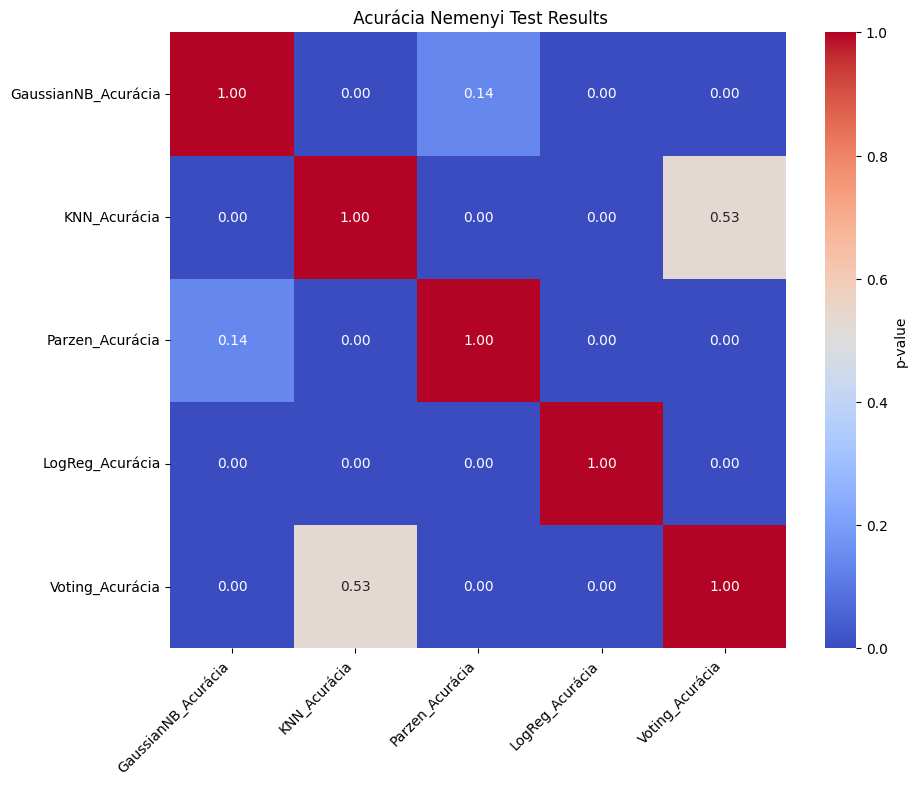

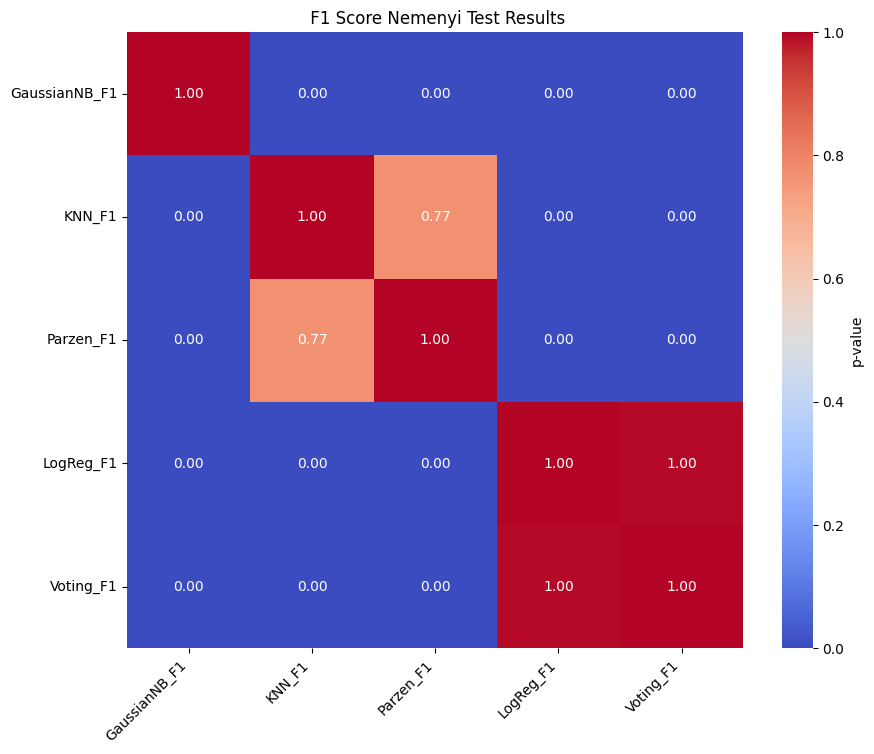

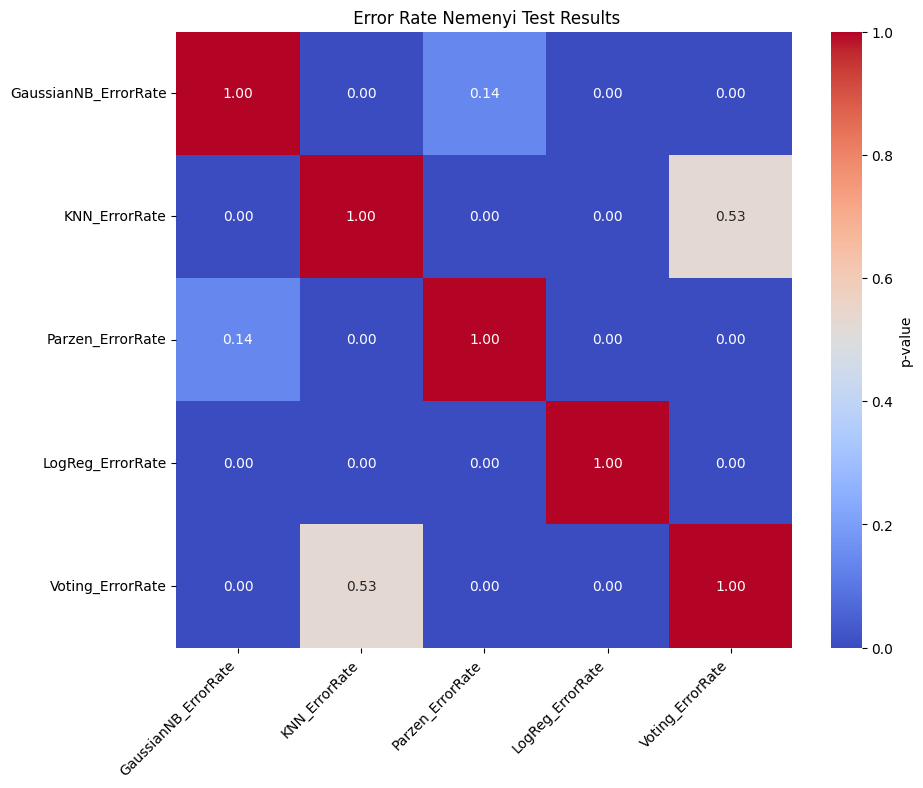

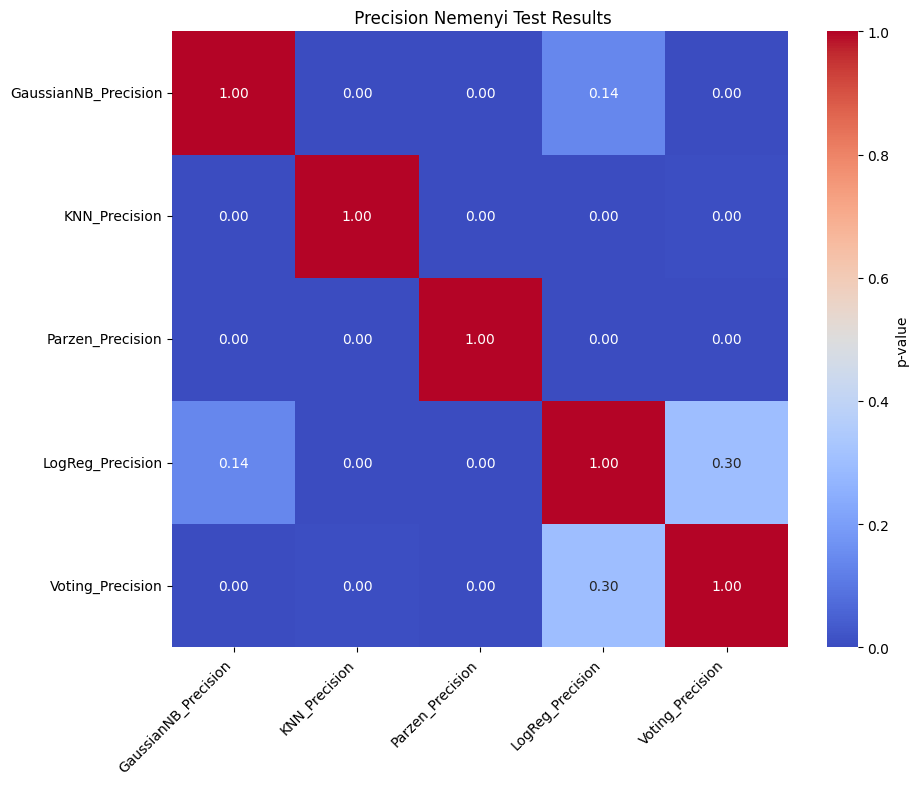

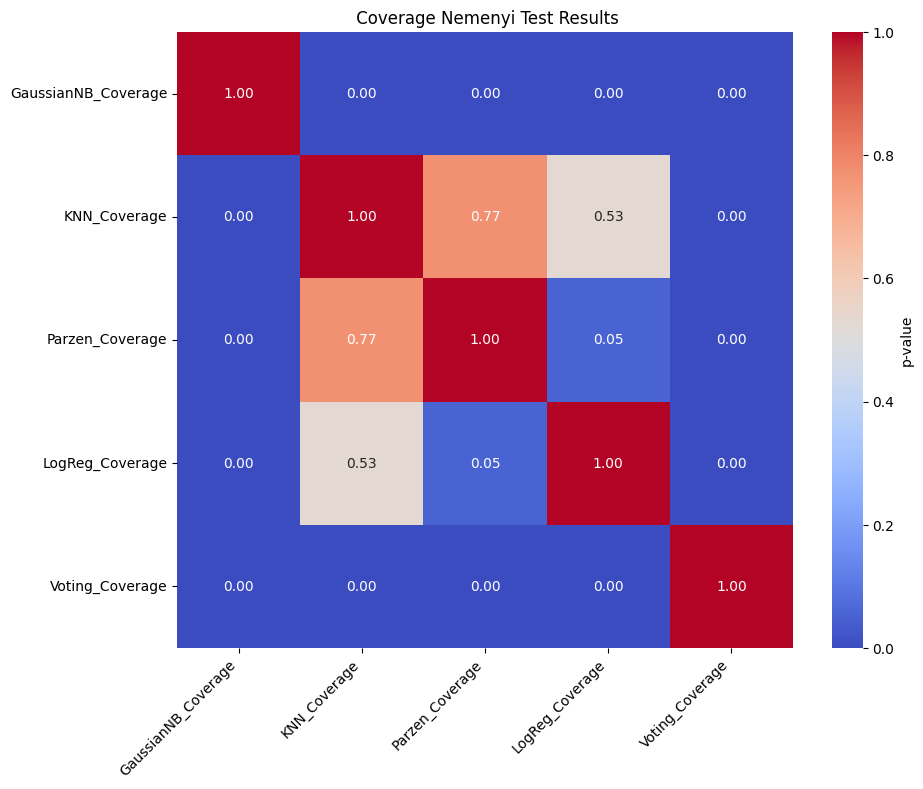

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(len(nemenyi_results)):
    # Suponha que nemenyi_results seja o DataFrame que você obteve do teste de Nemenyi
    plt.figure(figsize=(10, 8))  # Ajuste o tamanho da figura conforme necessário
    sns.heatmap(nemenyi_results[i], annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'p-value'})
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(f' {metric_names[i]} Nemenyi Test Results')
    plt.show()

## Questão 2d

d) Para cada metrica de avaliação, plot a curva de aprendizagem para o
classificador bayesiano Gaussiano. Usando amostragem estratificada, use 70%
dos dados para treinamento e 30% para teste. Treine o algoritmo com conjuntos
de treinamento de 5% a 100% do conjunto original de treinamento, com passo
de 5% (usando amostragem estratificada). Comente.

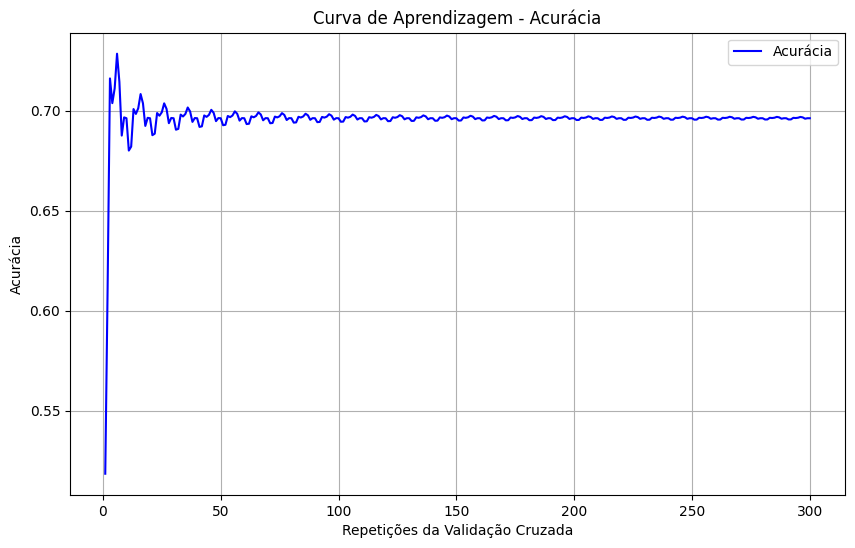

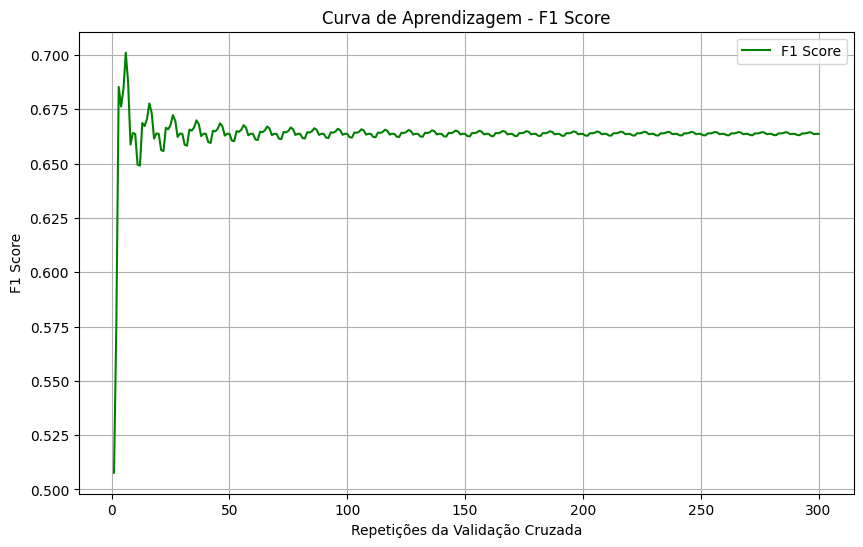

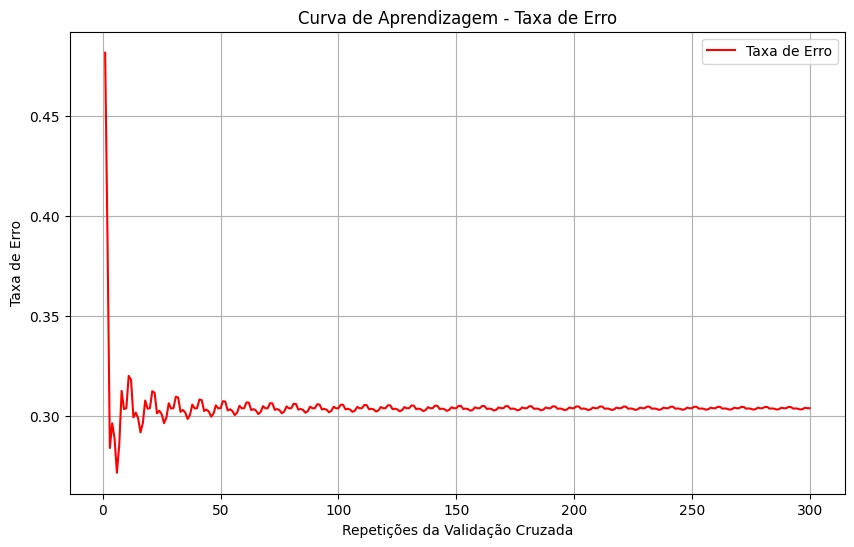

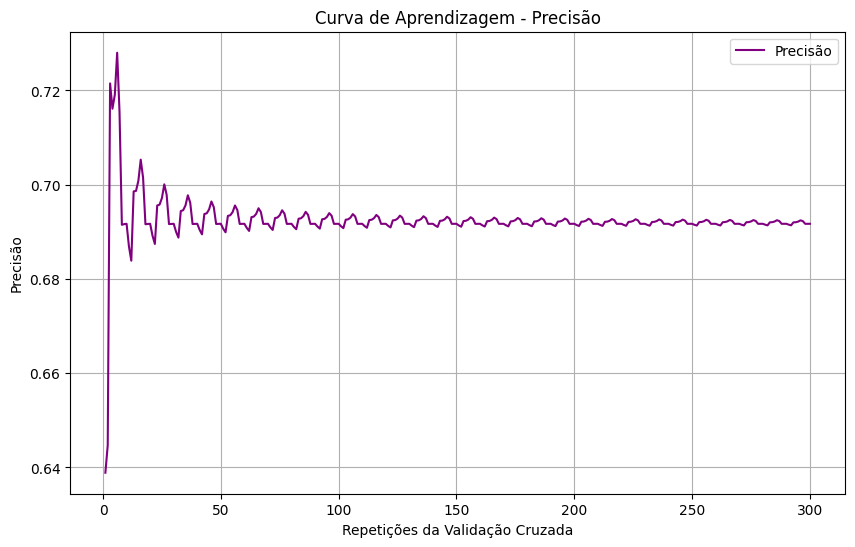

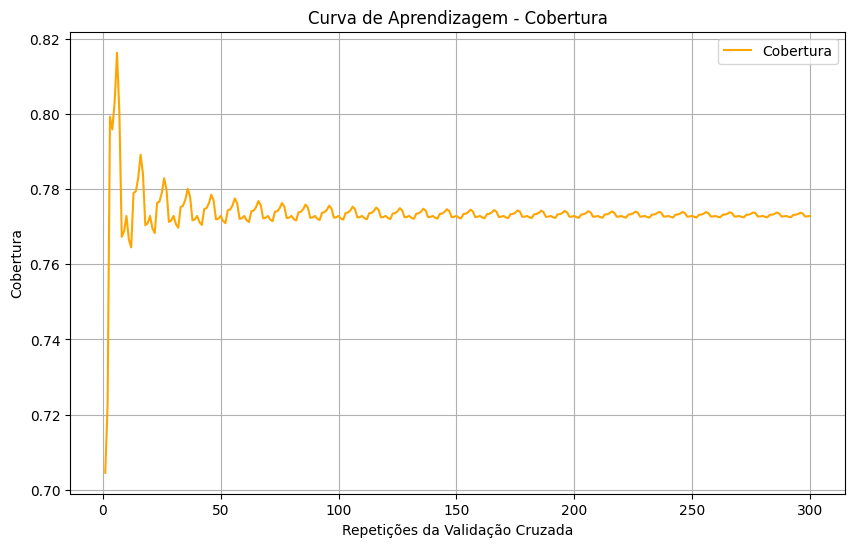

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para plotar curva de aprendizagem para uma métrica específica
def plot_learning_curve(metric_values, metric_name, color='b'):
    avg_values = np.cumsum(metric_values) / np.arange(1, len(metric_values) + 1)
    plt.plot(range(1, len(metric_values) + 1), avg_values, label=f'{metric_name}', color=color)
    plt.xlabel('Repetições da Validação Cruzada')
    plt.ylabel(metric_name)
    plt.title(f'Curva de Aprendizagem - {metric_name}')
    plt.legend()
    plt.grid()

# Curva de Acurácia
plt.figure(figsize=(10, 6))
plot_learning_curve(accuracies_gnb, 'Acurácia', color='blue')
plt.show()

# Curva de F1-score
plt.figure(figsize=(10, 6))
plot_learning_curve(f1_scores_gnb, 'F1 Score', color='green')
plt.show()

# Curva de Taxa de Erro
plt.figure(figsize=(10, 6))
plot_learning_curve(error_rates_gnb, 'Taxa de Erro', color='red')
plt.show()

# Curva de Precisão
plt.figure(figsize=(10, 6))
plot_learning_curve(precisions_gnb, 'Precisão', color='purple')
plt.show()

# Curva de Cobertura
plt.figure(figsize=(10, 6))
plot_learning_curve(coverages_gnb, 'Cobertura', color='orange')
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

# Supondo que X e y já estejam definidos como as variáveis de entrada (dados) e saída (rótulos)
# Dividindo os dados em treinamento e teste (70% treinamento e 30% teste) com amostragem estratificada
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Inicializar o classificador GNB
gnb = GaussianNB()

# Listas para armazenar as métricas para cada proporção do treinamento
accuracies, f1_scores, precisions, recalls = [], [], [], []

# Variar o tamanho do conjunto de treinamento de 5% a 100% com passo de 5%
for train_size in np.arange(0.05, 1.05, 0.05):  # 0.05 a 1.00 com incremento de 0.05
    # Garantir que test_size nunca seja 0
    test_size = max(0.01, 1 - train_size)

    # Selecionar uma fração do conjunto de treinamento
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, _ in stratified_split.split(X_train_full, y_train_full):
        # Usando iloc para indexar as linhas do DataFrame
        X_train = X_train_full.iloc[train_index]  # Usando iloc para DataFrame
        y_train = y_train_full[train_index]  # Usando indexação direta para o vetor numpy

        # Treinar o modelo GNB com o conjunto de treinamento selecionado
        gnb.fit(X_train, y_train)

        # Fazer as previsões no conjunto de teste
        y_pred = gnb.predict(X_test)

        # Calcular as métricas de desempenho
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))

# Criar o DataFrame para mostrar os resultados
results_df = pd.DataFrame({
    'Proporcao_Treinamento': np.arange(0.05, 1.05, 0.05),
    'Acurácia': accuracies,
    'F1': f1_scores,
    'Precisão': precisions,
    'Recall': recalls
})

# Exibir os resultados
print(results_df)


    Proporcao_Treinamento  Acurácia        F1  Precisão    Recall
0                    0.05  0.790123  0.441379  0.395062  0.500000
1                    0.10  0.777778  0.701230  0.687406  0.729779
2                    0.15  0.740741  0.699523  0.699312  0.792739
3                    0.20  0.703704  0.666667  0.679975  0.769301
4                    0.25  0.716049  0.677514  0.686111  0.777114
5                    0.30  0.691358  0.655905  0.674113  0.761489
6                    0.35  0.629630  0.602941  0.648103  0.722426
7                    0.40  0.604938  0.581935  0.638889  0.706801
8                    0.45  0.666667  0.634586  0.663110  0.745864
9                    0.50  0.679012  0.645216  0.668498  0.753676
10                   0.55  0.679012  0.645216  0.668498  0.753676
11                   0.60  0.666667  0.634586  0.663110  0.745864
12                   0.65  0.641975  0.613461  0.652930  0.730239
13                   0.70  0.641975  0.613461  0.652930  0.730239
14        

In [ ]:
# Dividindo os dados em treinamento e teste (70% treinamento e 30% teste) com amostragem estratificada
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Inicializar listas para armazenar os resultados
accuracies_gnb = []
f1_scores_gnb = []
precision_scores_gnb = []
recall_scores_gnb = []

# Número de repetições
n_repetitions = 30

# Definir as frações de dados de treinamento
train_sizes = np.arange(0.05, 1.05, 0.05)

# Verificar se X_train_full e y_train_full são DataFrames ou arrays numpy
# Caso sejam arrays numpy, utilizaremos o slicing adequado.

for train_size in train_sizes:
    accuracies = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    # Realizar 30 repetições para cada fração de dados
    for _ in range(n_repetitions):
        # Se train_size for 1.0, ajustamos o test_size para um valor pequeno
        test_size = 1 - train_size
        if test_size == 0:
            test_size = 0.01  # Garantir que o test_size seja sempre um valor válido

        stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=None)

        for train_index, test_index in stratified_split.split(X_train_full, y_train_full):
            # Se os dados forem arrays numpy, usamos o slicing direto
            if isinstance(X_train_full, np.ndarray):
                X_train = X_train_full[train_index]
                y_train = y_train_full[train_index]
                X_test = X_train_full[test_index]
                y_test = y_train_full[test_index]
            # Caso sejam DataFrames do pandas, usamos .iloc
            elif isinstance(X_train_full, pd.DataFrame):
                X_train = X_train_full.iloc[train_index, :]
                y_train = y_train_full[train_index]  # Para arrays, não usamos .iloc
                X_test = X_train_full.iloc[test_index, :]
                y_test = y_train_full[test_index]  # Para arrays, não usamos .iloc

            # Inicializar e treinar o classificador Naive Bayes Gaussiano
            gnb = GaussianNB()
            gnb.fit(X_train, y_train)

            # Fazer previsões
            y_pred_gnb = gnb.predict(X_test)

            # Calcular as métricas
            accuracies.append(accuracy_score(y_test, y_pred_gnb))
            f1_scores.append(f1_score(y_test, y_pred_gnb, average='macro'))
            precision_scores.append(precision_score(y_test, y_pred_gnb, average='macro', zero_division=0))
            recall_scores.append(recall_score(y_test, y_pred_gnb, average='macro'))

    # Calcular a média das métricas para esta proporção de dados
    accuracies_gnb.append(np.mean(accuracies))
    f1_scores_gnb.append(np.mean(f1_scores))
    precision_scores_gnb.append(np.mean(precision_scores))
    recall_scores_gnb.append(np.mean(recall_scores))

# Criar DataFrame com os resultados
results_df = pd.DataFrame({
    'Proporcao_Treinamento': train_sizes,
    'Acurácia': accuracies_gnb,
    'F1': f1_scores_gnb,
    'Precisão': precision_scores_gnb,
    'Recall': recall_scores_gnb
})

# Exibir os resultados
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

    Proporcao_Treinamento  Acurácia        F1  Precisão    Recall
0                    0.05  0.796610  0.443396  0.398305  0.500000
1                    0.10  0.801389  0.572798  0.662140  0.578088
2                    0.15  0.795597  0.692079  0.697787  0.708026
3                    0.20  0.784787  0.716349  0.704094  0.764300
4                    0.25  0.772857  0.710047  0.701224  0.762928
5                    0.30  0.764377  0.707289  0.697203  0.772537
6                    0.35  0.747107  0.696020  0.690764  0.773569
7                    0.40  0.736607  0.685180  0.684327  0.766023
8                    0.45  0.739159  0.690979  0.691156  0.778910
9                    0.50  0.734767  0.688196  0.689104  0.778568
10                   0.55  0.748810  0.701907  0.699337  0.793518
11                   0.60  0.735556  0.686783  0.688608  0.779722
12                   0.65  0.715657  0.667203  0.674702  0.764901
13                   0.70  0.727976  0.682358  0.687637  0.786094
14        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df

,Proporcao_Treinamento,Acurácia,F1,Precisão,Recall
0,0.05,0.796610,0.443396,0.398305,0.500000
1,0.10,0.801389,0.572798,0.662140,0.578088
2,0.15,0.795597,0.692079,0.697787,0.708026
3,0.20,0.784787,0.716349,0.704094,0.764300
4,0.25,0.772857,0.710047,0.701224,0.762928
5,0.30,0.764377,0.707289,0.697203,0.772537
6,0.35,0.747107,0.696020,0.690764,0.773569
7,0.40,0.736607,0.685180,0.684327,0.766023
8,0.45,0.739159,0.690979,0.691156,0.778910
9,0.50,0.734767,0.688196,0.689104,0.778568


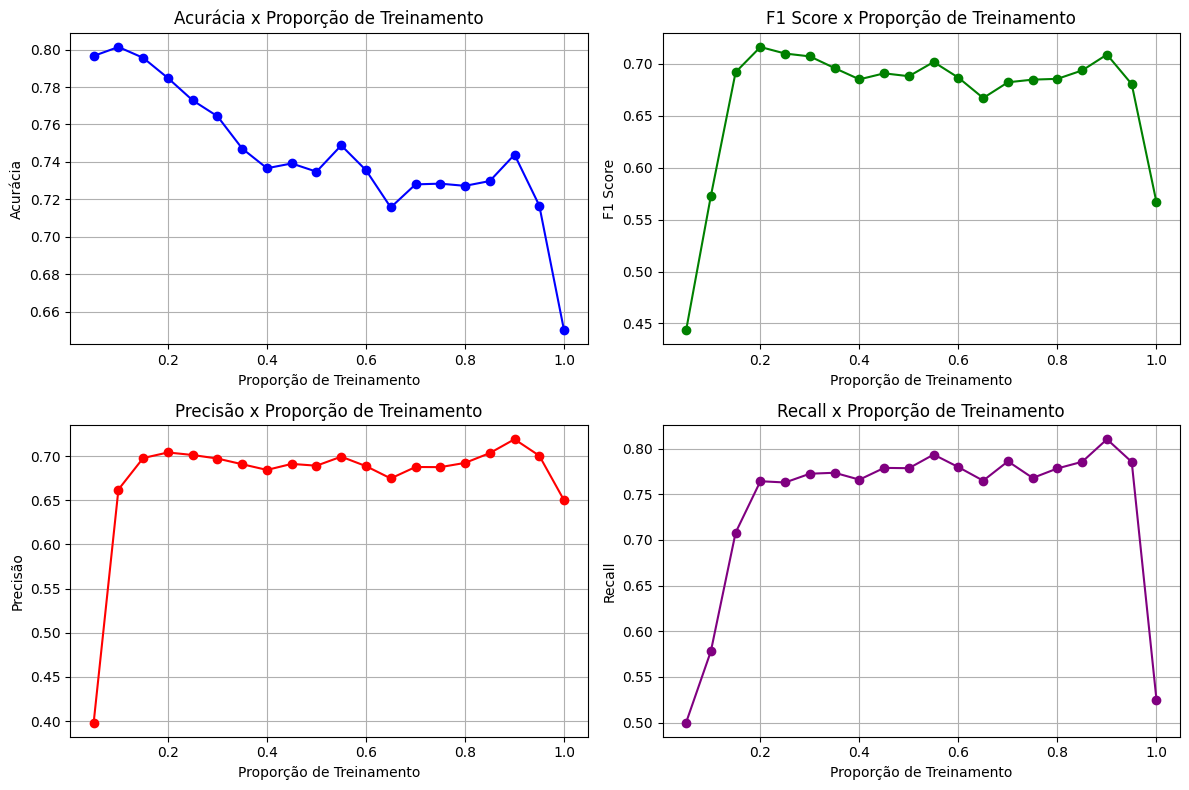

In [ ]:
import matplotlib.pyplot as plt

# Plotar as métricas para diferentes proporções de treinamento
plt.figure(figsize=(12, 8))

# Acurácia
plt.subplot(2, 2, 1)
plt.plot(train_sizes, accuracies_gnb, marker='o', color='b', label='Acurácia')
plt.title('Acurácia x Proporção de Treinamento')
plt.xlabel('Proporção de Treinamento')
plt.ylabel('Acurácia')
plt.grid(True)

# F1 Score
plt.subplot(2, 2, 2)
plt.plot(train_sizes, f1_scores_gnb, marker='o', color='g', label='F1 Score')
plt.title('F1 Score x Proporção de Treinamento')
plt.xlabel('Proporção de Treinamento')
plt.ylabel('F1 Score')
plt.grid(True)

# Precisão
plt.subplot(2, 2, 3)
plt.plot(train_sizes, precision_scores_gnb, marker='o', color='r', label='Precisão')
plt.title('Precisão x Proporção de Treinamento')
plt.xlabel('Proporção de Treinamento')
plt.ylabel('Precisão')
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(train_sizes, recall_scores_gnb, marker='o', color='purple', label='Recall')
plt.title('Recall x Proporção de Treinamento')
plt.xlabel('Proporção de Treinamento')
plt.ylabel('Recall')
plt.grid(True)

# Ajustar layout para melhor visualização
plt.tight_layout()
plt.show()
